In [91]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

In [92]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec
import matplotlib.pylab as pl
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

import fastcluster
from scipy.cluster.hierarchy import dendrogram
import scipy.cluster.hierarchy as hier

import networkx as nx
import networkx.algorithms.community as nxcom
import community
from collections import Counter
import pickle

In [93]:
num_datasets_per_comparison = {
'ATB_v_LTBI': 16,
'ATB_v_HC' : 15,
'ATB_v_OD': 10,
'LTBI_v_HC': 9}

#### set the *q-value* threshold & comparison

In [94]:
qval_thresh = 0.05

In [95]:
comparison_X = 'ATB_v_HC'

#### set parameters for plotting

In [96]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=1.0
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=False
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 14})

#### specify directory where differential gene data is stored

In [97]:
#use this path for personal computer
#diff_exp_data_dir = "/Users/rogervargas/OneDrive - Bill & Melinda Gates Medical Research Institute/Projects/Biomarkers/Data/Pooled Differential Gene Expression/"

#use this path for Gates MRI computer
#diff_exp_data_dir = "/Users/RogerVargas/OneDrive - Bill & Melinda Gates Medical Research Institute/Projects/Biomarkers/Data/Pooled Differential Gene Expression/"

#use this path for O2 computing cluster
diff_exp_data_dir = "/n/data1/hms/dbmi/farhat/Roger/gatesMRI/Projects/Biomarkers/Data/Pooled Differential Gene Expression/"

### *Function* for visualizing distribution of edge weights from pooled (significant) logFC changes across datasets

In [98]:
def plot_distribution_of_edge_weights(ax, edge_weight_distr_counter_dict, plot_title, linecolor):
    
    #convert Counter dict to series
    edge_weight_distr_series = pd.Series(edge_weight_distr_counter_dict).sort_index()
    
    #get the keys & values from Counter dict (with Edge Weight distr)
    edge_weight_values = edge_weight_distr_series.index
    edge_weight_count = edge_weight_distr_series.values
    edge_weight_count_norm = np.array(edge_weight_count) / float(np.sum(edge_weight_count)) #normalize counts
    
    ax.bar(edge_weight_values , edge_weight_count_norm, color = 'white' , width = 1.0 , edgecolor='black', linewidth=0.5)
    ax.bar(edge_weight_values[edge_weight_distr_series.index <= -3] , edge_weight_count_norm[edge_weight_distr_series.index <= -3], color = 'blue' , width = 1.0 , edgecolor='black', linewidth=0.5)
    ax.bar(edge_weight_values[edge_weight_distr_series.index >= 3] , edge_weight_count_norm[edge_weight_distr_series.index >= 3], color = 'blue' , width = 1.0 , edgecolor='black', linewidth=0.5)
    ax.plot(edge_weight_values , edge_weight_count_norm, color = linecolor , linewidth = 2.5)
    
    # calculate the number of the edges that had weight <= -3
    negative_edge_weights_for_network = edge_weight_count[edge_weight_distr_series.index <= -3].sum()
    
    # calculate the number of the edges that had weight >= 3
    positive_edge_weights_for_network = edge_weight_count[edge_weight_distr_series.index >= 3].sum()

    ax.set_title(plot_title, fontsize = 12, color = 'k')
    ax.set_ylabel('Proportion of Edges', fontsize = 12, color = 'k')
    ax.set_xlabel(f'Edge Weights \n (Num Edges <= -3: {negative_edge_weights_for_network}) \n (Num Edges >= 3: {positive_edge_weights_for_network})' , fontsize = 12, color = 'k')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(False)
    ax.set_yscale('log')

    ax.tick_params(labelcolor = 'k')
    ax.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
    ax.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')
    
    for axis in [ax.yaxis]:
        axis.set_major_formatter(FormatStrFormatter('%.5f'))
        
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

#### set parameters for plotting

In [99]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=1.0
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=False
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 14})

## Compute Edges (and corresponding weights) from pooled logFC matrix

In [100]:
logFC_table_filename = f'{comparison_X}_signif_logFC_qval_thresh_{qval_thresh}.csv'

# read in CSV file with significant logFC changes for genes between comparison X samples collected from various datasets
diff_gene_exp_df = pd.read_csv(diff_exp_data_dir + logFC_table_filename).set_index('Unnamed: 0')
diff_gene_exp_df.rename_axis('gene' , inplace = True)

# Construct simplified matrix of logFC direction from DataFrame with significant logFC changes across all analyses by converting values:
# +1 if logFC > 0
#  0 if logFC = 0
# -1 if logFC < 0

# store copy of array from dataframe with sig. logFC values (rows = genes, columns = GSE ID)
direc_diff_gene_exp_matrix = diff_gene_exp_df.copy().values 

# replace values in logFC matrix
direc_diff_gene_exp_matrix[direc_diff_gene_exp_matrix > 0.0] = 1
direc_diff_gene_exp_matrix[direc_diff_gene_exp_matrix == 0.0] = 0
direc_diff_gene_exp_matrix[direc_diff_gene_exp_matrix < 0.0] = -1

# convert to lower memory int8 datatype
direc_diff_gene_exp_matrix = direc_diff_gene_exp_matrix.astype('int8')

# compute the dot product between every two pairs of gene vectors (will calculate the edges weights for our network)
# Compute $M \cdot M^T \text{ to get } i \cdot j \text{ , } \forall \text{ pairs of rows } i, j \text{ in matrix } M$
# multiply direction logFC matrix by its transpose to get the dot products between all pairs of rows
network_edge_weight_matrix = direc_diff_gene_exp_matrix.dot(direc_diff_gene_exp_matrix.T)

# the row/column annotation (genes) can be copied from the logFC differential gene expression DataFrame
network_edge_weight_matrix_labels = pd.Series(list(diff_gene_exp_df.index) , index = range(0 , len(diff_gene_exp_df.index)))

# DISTRIBUTION OF EDGE WEIGHTS

#number of rows / columns
num_genes = np.shape(network_edge_weight_matrix)[0]

# retrieve the distribution of the Edge Weights by returning the upper triangular part of the matrix
edge_weight_array = network_edge_weight_matrix[np.triu_indices(num_genes, k = 0)]

#convert array to a Counter dict to save space (keys: edge weight values, values: count of edge weights in edge weight distribution)
edge_weight_distr_counter_dict = Counter(list(edge_weight_array))

In [101]:
network_edge_weight_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 2, 0, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 1]], dtype=int8)

In [102]:
np.shape(network_edge_weight_matrix)

(30468, 30468)

In [103]:
network_edge_weight_matrix_labels.head()

0     KRT36
1     KIFC3
2      REG4
3     FADS2
4    FANCD2
dtype: object

In [104]:
np.shape(network_edge_weight_matrix_labels)

(30468,)

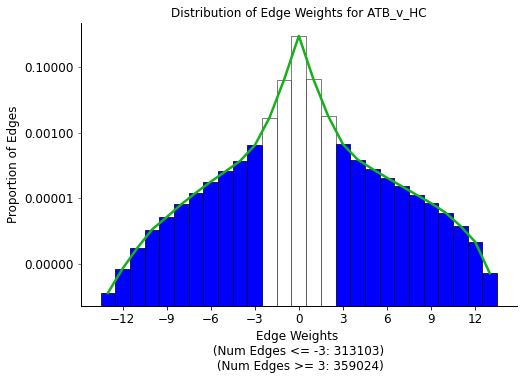

In [105]:
fig , ax = plt.subplots()

plot_distribution_of_edge_weights(ax, edge_weight_distr_counter_dict, f'Distribution of Edge Weights for {comparison_X}', 'xkcd:green')

fig = plt.gcf()
fig.set_size_inches(7.5, 5.5)
fig.tight_layout()

#file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/lab_meeting_12_12_19/pairwise_SNP_distance/distribution_of_pairwise_SNP_distances.png'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

#### minimum/maximum edge weights

In [106]:
np.min(network_edge_weight_matrix)

-13

In [107]:
np.max(network_edge_weight_matrix)

13

## Construct NetworkX graph from edge weight matrix

#### Retrieve the indices for the upper-triangular part of the matrix, normalize edge weights & construct list of edges

Have to (1) retrieve the edges from the upper-triangle of the matrix, (2) convert all to positive edge weights & (3) divide by the number of datasets

In [108]:
#Return the upper triangular part of the matrix with elements in lower part ZEROED out
upper_tri_network_edge_weight_matrix = np.triu(network_edge_weight_matrix, k = 0)

#Return a boolean for elements in the upper triangular part of the matrix for elments that are <= -3 OR >= 3
upper_tri_network_edge_weight_matrix_bool = abs(upper_tri_network_edge_weight_matrix) >= 3

#get the indices for the elements in the upper triangle where elements (edge weights) <= -3 OR >= 3
node_i_indices = upper_tri_network_edge_weight_matrix_bool.nonzero()[0]
node_j_indices = upper_tri_network_edge_weight_matrix_bool.nonzero()[1]

#get the normalization factor (number of datasets used to construct edge weights = maximum possible weight)
edge_weight_norm_factor = float(num_datasets_per_comparison[comparison_X])

#Create list of edges for NetworkX graph by iterating through numpy (adjancency) matrix (with edge weights) + node labels (rows/columns of matrix) & storing edges with weights <= -3 OR >= 3
G_edge_list = [ ( network_edge_weight_matrix_labels[node_i], network_edge_weight_matrix_labels[node_j], (float(abs(network_edge_weight_matrix[node_i, node_j]))/edge_weight_norm_factor) ) for node_i, node_j in zip(node_i_indices, node_j_indices)]

In [109]:
G_edge_list[0:10]

[('USB1', 'USB1', 0.3333333333333333),
 ('USB1', 'C12orf57', 0.26666666666666666),
 ('USB1', 'CD6', 0.26666666666666666),
 ('USB1', 'ZNF329', 0.2),
 ('USB1', 'BLVRA', 0.26666666666666666),
 ('USB1', 'CHMP5', 0.2),
 ('USB1', 'P2RY10', 0.2),
 ('USB1', 'TRIM32', 0.2),
 ('USB1', 'BCL3', 0.2),
 ('USB1', 'ACAD11', 0.2)]

In [110]:
len(G_edge_list) #number of edges (gene-gene pairs with edge weights <= -3 OR >= 3)

672127

#### Construct NetworkX graph from list of Edges

In [111]:
G = nx.Graph()
G.add_weighted_edges_from(G_edge_list)

In [112]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 3005
Number of edges: 672127
Average degree: 447.3391


## Visualize network

Use **Spring Layout** to set the positions of the nodes

In [173]:
pos = nx.spring_layout(G , k = 0.35 , weight = 'weight' , iterations = 100)

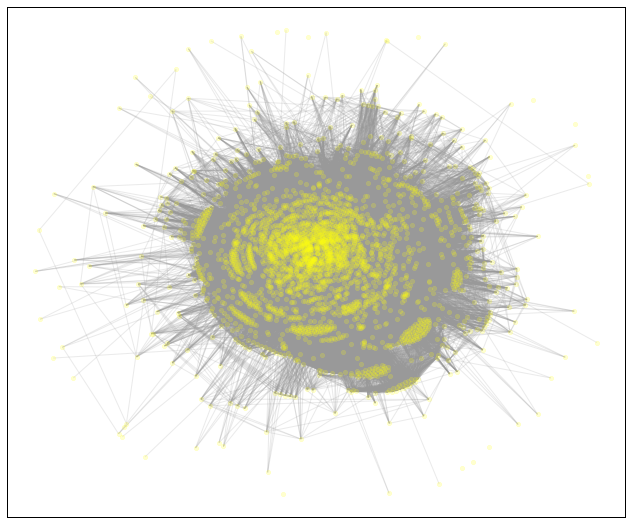

In [174]:
fig , ax = plt.subplots()

nx.draw_networkx(
    G, 
    pos = pos, 
    ax = ax,
    node_size = 20, 
    node_color = 'xkcd:yellow',
    edge_color = "0.6",
    alpha = 0.2, 
    with_labels = False)

fig = plt.gcf()
fig.set_size_inches(9.0, 7.5)
fig.tight_layout()
plt.show()

#### *Function* to color a subset of nodes differently

In [115]:
def draw_graph_and_color_subset_nodes(G, nodes_in_group, ax):

    '''
    This function takes in a graph, list of a subset of nodes and axis object,
    then draws the network with the subset of nodes colored seperately from the 
    rest of the nodes in the network
    '''

    #draw nodes NOT in the (subset) group
    size_map = []
    for node in G:
        if node not in nodes_in_group:
            size_map.append(25)
        elif node in nodes_in_group:
            size_map.append(0)

    nx.draw_networkx(
        G, 
        ax = ax,
        pos=pos, 
        node_size=size_map, 
        node_color = 'xkcd:grey',
        linewidths = 0.0,
        edge_color="0.7",
        width=0.0,
        alpha=0.25, 
        with_labels=False)

    #draw nodes that ARE in the (subset) group
    size_map = []
    for node in G:
        if node not in nodes_in_group:
            size_map.append(0)
        elif node in nodes_in_group:
            size_map.append(25)

    nx.draw_networkx(
        G, 
        pos=pos, 
        ax = ax,
        node_size=size_map, 
        node_color = 'xkcd:black',
        linewidths = 0.0,
        edge_color="0.7",
        width=0.0,
        alpha=0.7, 
        with_labels=False)

## Centrality of Nodes from NetworkX graph

Get a series of the **Degree** for each node

In [116]:
node_list = [node_deg[0] for node_deg in list(G.degree())]
degree_list = [node_deg[1] for node_deg in list(G.degree())]
degree_series = pd.Series(degree_list , index = node_list).sort_values(ascending = False)

Get a series of the **Degree Centrality** and the **Eigenvector Centrality** for each node

In [117]:
degree_centrality_series = pd.Series(nx.degree_centrality(G)).sort_values(ascending = False) #doesn't take edge weight into account
eigenvector_centrality_series = pd.Series(nx.eigenvector_centrality(G, weight = 'weight')).sort_values(ascending = False) #takes edge weight into account

Plot the distibution of **centrality** values for all nodes

/home/rv76/anaconda2/envs/py36_MRI_virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


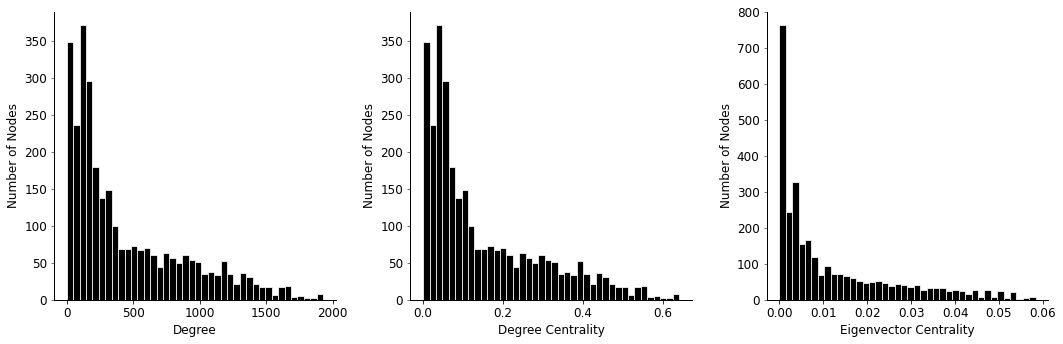

In [118]:
fig = plt.figure(constrained_layout=True)

gs = GridSpec(1, 3, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

#DEGREE CENTRALITY
ax1.hist(degree_series , bins = 40, color = 'black' , rwidth = 1.0 , edgecolor='white', linewidth=0.75)

ax1.set_ylabel('Number of Nodes', fontsize = 12, color = 'k')
ax1.set_xlabel(f'Degree' , fontsize = 12, color = 'k')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.grid(False)
ax1.tick_params(labelcolor = 'k')
ax1.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
ax1.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')

#DEGREE CENTRALITY
ax2.hist(degree_centrality_series , bins = 40, color = 'black' , rwidth = 1.0 , edgecolor='white', linewidth=0.75)

ax2.set_ylabel('Number of Nodes', fontsize = 12, color = 'k')
ax2.set_xlabel(f'Degree Centrality' , fontsize = 12, color = 'k')

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.grid(False)
ax2.tick_params(labelcolor = 'k')
ax2.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
ax2.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')
    
#EIGENVECTOR CENTRALITY
ax3.hist(eigenvector_centrality_series , bins = 40, color = 'black' , rwidth = 1.0 , edgecolor='white', linewidth=0.75)

ax3.set_ylabel('Number of Nodes', fontsize = 12, color = 'k')
ax3.set_xlabel(f'Eigenvector Centrality' , fontsize = 12, color = 'k')

ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.grid(False)
ax3.tick_params(labelcolor = 'k')
ax3.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
ax3.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')
    
################### Plot ###################
fig = plt.gcf()
fig.set_size_inches(15, 5.0)
fig.tight_layout()

#file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/lab_meeting_12_12_19/pairwise_SNP_distance/distribution_of_pairwise_SNP_distances.png'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

In [119]:
degree_series.head(n=10)

AIM2       1927
SORT1      1927
GBP5       1927
PIK3IP1    1927
SAMD9L     1927
IFITM3     1927
CARD16     1927
ANKRD22    1904
SLC6A12    1874
BATF2      1874
dtype: int64

In [120]:
degree_centrality_series.head(n=10)

AIM2       0.641478
SORT1      0.641478
GBP5       0.641478
PIK3IP1    0.641478
SAMD9L     0.641478
IFITM3     0.641478
CARD16     0.641478
ANKRD22    0.633822
SLC6A12    0.623835
BATF2      0.623835
dtype: float64

In [121]:
eigenvector_centrality_series.head(n=10)

GBP5       0.058306
AIM2       0.058306
SAMD9L     0.058306
CARD16     0.058306
SORT1      0.058306
IFITM3     0.058306
PIK3IP1    0.058306
ANKRD22    0.055686
TLR5       0.055415
GBP2       0.055415
dtype: float64

How does the ranking of centrality values between **Degree** and **Eigenvector** centrality compare?

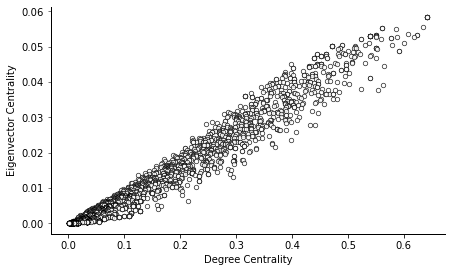

In [122]:
fig , ax = plt.subplots()

ax.scatter(degree_centrality_series[eigenvector_centrality_series.index], eigenvector_centrality_series , color = 'white' , linewidth=0.75 , edgecolor = 'black' , s = 20 , alpha = 0.8)

#ax.set_title('Degree vs. Eigenvector Centrality', fontsize = 10, color = 'k')
ax.set_ylabel('Eigenvector Centrality', fontsize = 10, color = 'k')
ax.set_xlabel('Degree Centrality' , fontsize = 10, color = 'k')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)
ax.tick_params(labelcolor = 'k')
ax.tick_params(axis='y', which='major', labelsize=10 , labelcolor = 'k')
ax.tick_params(axis='x', which='major', labelsize=10 , labelcolor = 'k')

fig = plt.gcf()
fig.set_size_inches(6.5, 4.0)
fig.tight_layout()

#file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/lab_meeting_12_12_19/pairwise_SNP_distance/distribution_of_pairwise_SNP_distances.png'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

In [ ]:
for edge in eigenvector_centrality_series.head(n=200).index:
    print(edge)

Where are the most **central** nodes located in the network?

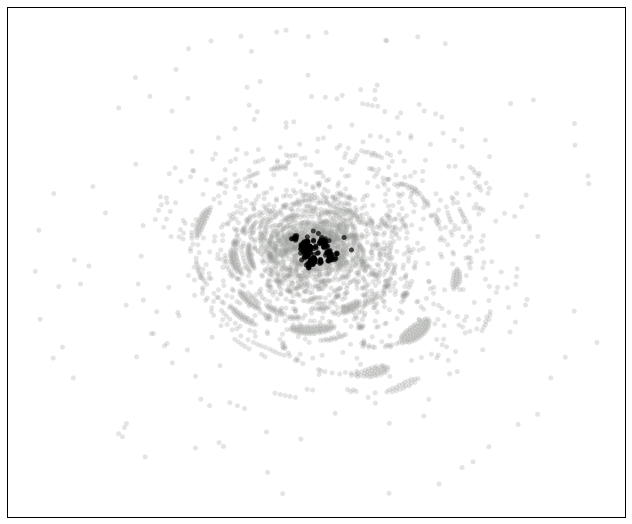

In [176]:
central_nodes = set(eigenvector_centrality_series[0:200].index)

fig , ax = plt.subplots()

draw_graph_and_color_subset_nodes(G, central_nodes, ax)

fig = plt.gcf()
fig.set_size_inches(9.0, 7.5)
fig.tight_layout()
plt.show()

## Analyze Transcription Factors

Load list of transcription factors from CSV file

In [140]:
TF_df = pd.read_csv("/n/data1/hms/dbmi/farhat/Roger/gatesMRI/Projects/Biomarkers/Data/Transcription Factor list/DatabaseExtract_v_1.01.csv").set_index('Unnamed: 0')

In [141]:
TF_df.head()

,Ensembl ID,HGNC symbol,DBD,Is TF?,TF assessment,Binding mode,Motif status,Final Notes,Final Comments,Interpro ID(s),...,CisBP considers it a TF?,TFCat classification,Is a GO TF?,Initial assessment,Curator 1,Curator 2,TFclass considers it a TF?,Go Evidence,Pfam Domains (By ENSP ID),Is C2H2 ZF(KRAB)?
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0,ENSG00000137203,TFAP2A,AP-2,Yes,Known motif,Monomer or homomultimer,High-throughput in vitro,None,None,IPR008121;IPR013854,...,Yes,TF Gene_DNA-Binding: sequence-specific_DNA Bin...,Yes,"1a1, Direct HQ evidence",Sam Lambert,Yimeng Yin,Yes,$#ENSG00000137203#GO:0000981#sequence-specific...,$#ENSP00000368928#ENSG00000137203#ENST00000379...,False
1,ENSG00000008196,TFAP2B,AP-2,Yes,Known motif,Monomer or homomultimer,High-throughput in vitro,None,None,IPR008122;IPR013854,...,Yes,TF Gene_DNA-Binding: sequence-specific_DNA Bin...,Yes,"1a1, Direct HQ evidence",Matt Weirauch,Yimeng Yin,Yes,$#ENSG00000008196#GO:0000981#sequence-specific...,$#ENSP00000377265#ENSG00000008196#ENST00000393...,False
2,ENSG00000087510,TFAP2C,AP-2,Yes,Known motif,Monomer or homomultimer,High-throughput in vitro,None,None,IPR008123;IPR013854,...,Yes,No,Yes,"1a1, Direct HQ evidence",Matt Weirauch,Yimeng Yin,Yes,$#ENSG00000087510#GO:0001077#RNA polymerase II...,$#ENSP00000201031#ENSG00000087510#ENST00000201...,False
3,ENSG00000008197,TFAP2D,AP-2,Yes,Known motif,Monomer or homomultimer,In vivo/Misc source,Only known motifs are from Transfac or HocoMoc...,Binds the same GCCTGAGGC sequence as the other...,IPR013854;,...,Yes,No,Yes,"2a1, Lower confidence direct evidence",Arttu Jolma,Sam Lambert,Yes,$#ENSG00000008197#GO:0000981#sequence-specific...,$#ENSP00000008391#ENSG00000008197#ENST00000008...,False
4,ENSG00000116819,TFAP2E,AP-2,Yes,Known motif,Monomer or homomultimer,High-throughput in vitro,None,None,IPR013854;,...,Yes,TF Gene_DNA-Binding: sequence-specific_DNA Bin...,Yes,"1a1, Direct HQ evidence",Sam Lambert,Laura Campitelli,Yes,$#ENSG00000116819#GO:0000981#sequence-specific...,$#ENSP00000362332#ENSG00000116819#ENST00000373...,False


In [142]:
np.shape(TF_df)

(2765, 28)

Keep only the genes from list that are Transcription Factors

In [143]:
TF_df = TF_df[TF_df.loc[: , 'Is TF?'] == 'Yes']
TF_df.reset_index(inplace = True , drop = True)

In [144]:
np.shape(TF_df)

(1639, 28)

Get list of TFs using the HGNC gene symbols

In [145]:
TF_list = list(TF_df.loc[: , 'HGNC symbol'])

In [146]:
len(TF_list)

1639

#### Get the centrality for the transcription factors that are present in nodes in the graph

In [147]:
TF_node_gene_list = []
TF_node_centrality_list = []

gene_nodes_in_G = set(eigenvector_centrality_series.index)

for gene_i in TF_list:
    
    if gene_i in gene_nodes_in_G:
        
        TF_node_gene_list.append(gene_i)
        TF_node_centrality_list.append(eigenvector_centrality_series[gene_i])
        
TF_centrality_series = pd.Series(TF_node_centrality_list, index = TF_node_gene_list).sort_values(ascending = False)

In [148]:
TF_centrality_series.head(n=20)

BATF2     0.053338
STAT1     0.053072
ZNF91     0.050616
ZNF438    0.050155
TRAFD1    0.047832
PLSCR1    0.047482
ETV7      0.045188
LEF1      0.045042
ZNF827    0.042439
STAT2     0.042006
ETS1      0.041787
ZNF831    0.040151
ZNF395    0.040055
OLIG1     0.039737
ZNF256    0.039307
IRF1      0.037544
ZNF529    0.037476
MAFB      0.035768
LTF       0.034168
KLF12     0.033783
dtype: float64

In [149]:
len(TF_centrality_series)

281

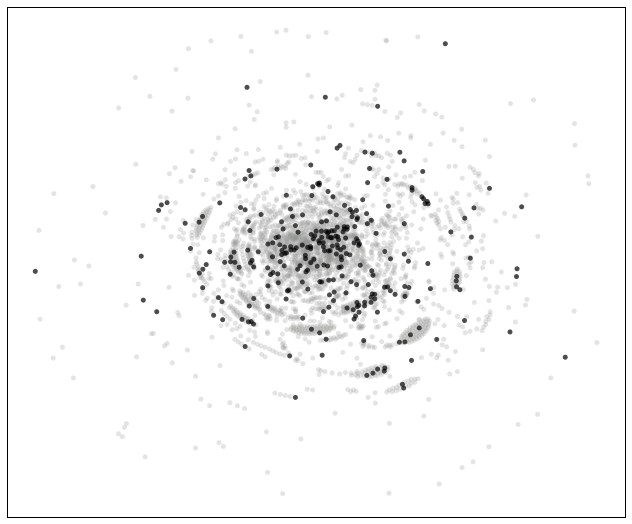

In [177]:
fig , ax = plt.subplots()

draw_graph_and_color_subset_nodes(G, list(TF_centrality_series.index), ax)

fig = plt.gcf()
fig.set_size_inches(9.0, 7.5)
fig.tight_layout()
plt.show()

Plot the distribution of centrality for nodes in the network that are transcription factors

In [151]:
eigenvector_centrality_TF_thresh = 0.03

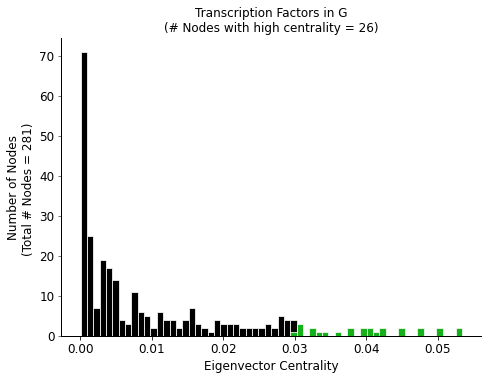

In [152]:
fig , ax = plt.subplots()

n, bins, patches = ax.hist(TF_centrality_series , bins = 60, color = 'black' , rwidth = 1.0 , edgecolor='white', linewidth=0.75)
ax.hist(TF_centrality_series[TF_centrality_series >= eigenvector_centrality_TF_thresh] , bins = bins, color = 'xkcd:green' , rwidth = 1.0 , edgecolor='white', linewidth=0.75)

ax.set_title(f'Transcription Factors in G\n(# Nodes with high centrality = {len(TF_centrality_series[TF_centrality_series >= eigenvector_centrality_TF_thresh].index)})', fontsize = 12, color = 'k')
ax.set_ylabel(f'Number of Nodes\n(Total # Nodes = {len(TF_centrality_series.index)}) ', fontsize = 12, color = 'k')
ax.set_xlabel('Eigenvector Centrality' , fontsize = 12, color = 'k')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)
ax.tick_params(labelcolor = 'k')
ax.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
ax.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')

fig = plt.gcf()
fig.set_size_inches(7.0, 5.5)
fig.tight_layout()

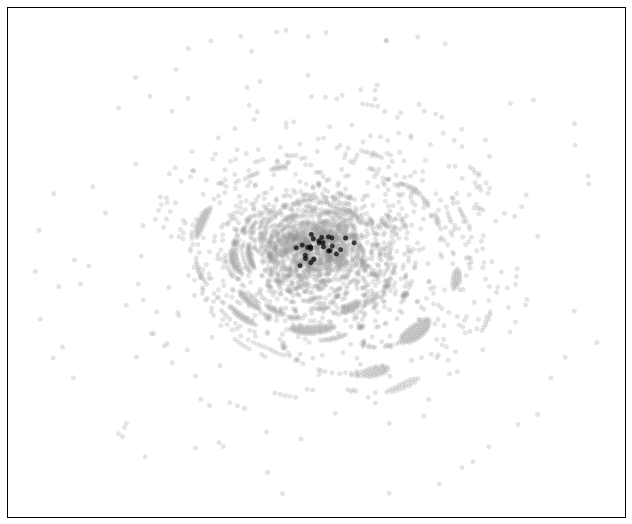

In [178]:
fig , ax = plt.subplots()

draw_graph_and_color_subset_nodes(G, list(TF_centrality_series[TF_centrality_series >= eigenvector_centrality_TF_thresh].index), ax)

fig = plt.gcf()
fig.set_size_inches(9.0, 7.5)
fig.tight_layout()
plt.show()

In [179]:
for gene_i in TF_centrality_series[TF_centrality_series >= eigenvector_centrality_TF_thresh].index:
    print(gene_i)

BATF2
STAT1
ZNF91
ZNF438
TRAFD1
PLSCR1
ETV7
LEF1
ZNF827
STAT2
ETS1
ZNF831
ZNF395
OLIG1
ZNF256
IRF1
ZNF529
MAFB
LTF
KLF12
IRF7
ZSCAN18
ZNF439
ZNF30
SP140
SPIB


In [180]:
TF_centrality_series.head(n=40)

BATF2      0.053338
STAT1      0.053072
ZNF91      0.050616
ZNF438     0.050155
TRAFD1     0.047832
PLSCR1     0.047482
ETV7       0.045188
LEF1       0.045042
ZNF827     0.042439
STAT2      0.042006
ETS1       0.041787
ZNF831     0.040151
ZNF395     0.040055
OLIG1      0.039737
ZNF256     0.039307
IRF1       0.037544
ZNF529     0.037476
MAFB       0.035768
LTF        0.034168
KLF12      0.033783
IRF7       0.032653
ZSCAN18    0.032149
ZNF439     0.031028
ZNF30      0.031028
SP140      0.030719
SPIB       0.030135
ATF3       0.029911
SOX8       0.029741
GATA3      0.029394
HSF2       0.029071
ZNF540     0.028907
RBCK1      0.028757
CREB5      0.028714
ZNF548     0.028433
ZNF248     0.028196
BCL6       0.027873
TSHZ3      0.027854
PBX4       0.027669
STAT4      0.026973
ZNF573     0.026727
dtype: float64

Gets the ranking of the TF centralities for the ATB v HC comparison group and stores as a dict

In [189]:
ATB_v_HC_TF_centrality_rank_dict = [[gene_symbol , gene_index] for gene_symbol, gene_index in zip(TF_centrality_series.index , range(1 , len(TF_centrality_series)+1))]

In [ ]:
ATB_v_HC_TF_centrality_rank_dict

## Communities in NetworkX graph

Find communities using the **Louvain** algorithm

Completed Louvain algorithm .. . . 
Modularity:  0.19343050282897398
Total number of Communities= 21


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


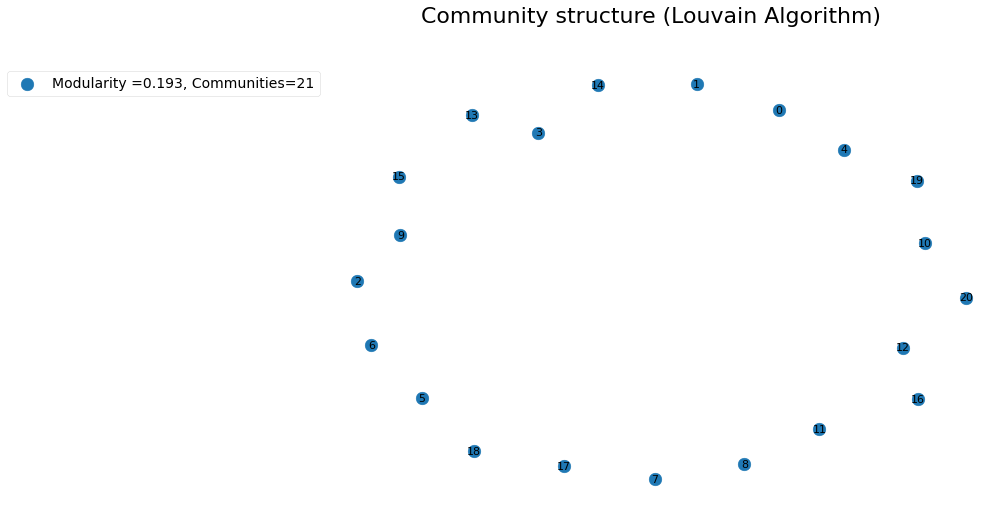

In [156]:
# Starting with an initial partition of the graph and running the Louvain algorithm for Community Detection
partition=community.best_partition(G, weight='weight')
print('Completed Louvain algorithm .. . . ' )
values=[partition.get(node) for node in G.nodes()]
list_com=partition.values()

# Creating a dictionary like {community_number:list_of_participants}
dict_nodes={}

# Populating the dictionary with items
for each_item in partition.items():
    community_num=each_item[1]
    community_node=each_item[0]
    if community_num in dict_nodes:
        value=dict_nodes.get(community_num) + ' | ' + str(community_node)
        dict_nodes.update({community_num:value})
    else:
        dict_nodes.update({community_num:community_node})

# Creating a dataframe from the dict, and getting the output into excel
community_df=pd.DataFrame.from_dict(dict_nodes, orient='index',columns=['Members'])
community_df.index.rename('Community_Num' , inplace=True)
num_comm_members = [len(comm_i_member_list.split(' | ')) for comm_i_member_list in community_df.Members]
community_df.loc[: , 'Num_Members'] = num_comm_members
## community_df.to_csv('Community_List_snippet.csv')

# Creating a new graph to represent the communities created by the Louvain algorithm
plt.rcParams['figure.figsize']= [12, 8]
G_comm=nx.Graph()

# Populating the data from the node dictionary created earlier
G_comm.add_nodes_from(dict_nodes)

# Calculating modularity and the total number of communities
mod=community.modularity(partition,G)
print("Modularity: ", mod)
print("Total number of Communities=", len(G_comm.nodes()))

# Creating the Graph and also calculating Modularity
plt.rcParams['figure.figsize']= [12, 8]
pos_louvain=nx.spring_layout(G_comm)
nx.draw_networkx(G_comm, pos_louvain, with_labels=True,node_size=160,font_size=11,label='Modularity =' + str(round(mod,3)) +
                    ', Communities=' + str(len(G_comm.nodes())))
plt.suptitle('Community structure (Louvain Algorithm)',fontsize=22,fontname='Arial')
plt.box(on=None)
plt.axis('off')
plt.legend(bbox_to_anchor=(0,1), loc='best', ncol=1)
## plt.savefig('louvain.png',dpi=400, bbox_inches='tight')

In [157]:
community_df.head(n=20)

,Members,Num_Members
Community_Num,,
0,USB1 | C12orf57 | ZNF329 | CHMP5 | TRIM32 | BC...,671
1,CD6 | BLVRA | FBXO31 | CNNM3 | SERPING1 | CLEC...,583
2,P2RY10 | CLEC2D | NOC3L | IGFLR1 | SYTL2 | NUP...,875
3,NBN | SARM1 | PLA2G4A | STMN3 | HNRNPH1 | IRAK...,806
4,KRT23,1
5,ASF1B | FAM153B | CDH24 | FAM153A | NOP10 | PF...,10
6,TTC9C | VENTX | ZAK | RFX7 | EDEM3 | MED20 | Y...,40
7,KIAA0895L,1
8,PELP1,1


In [158]:
def draw_community_subgraph_network_and_edge_weight_distribution(comm_i):
    
    #get the set of nodes within the community
    nodes_in_community = set(community_df.loc[comm_i, 'Members'].split(' | '))
    number_of_nodes = len(nodes_in_community)

    #get the subgraph generated by nodes in community
    G_community_subgraph = G.subgraph(list(nodes_in_community)) 

    #get edge weight distribution for community
    edge_weights_community = [data['weight'] for node1, node2, data in G_community_subgraph.edges(data=True)]
    community_avg_edge_weight = round(np.mean(edge_weights_community), 4)

    ############ create figure & axes ############
    fig = plt.figure(constrained_layout=True)

    gs = GridSpec(1, 2, figure=fig)

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])

    ############ draw the network & color the community differently ############
    draw_graph_and_color_subset_nodes(G, nodes_in_community, ax1)

    ############ plot the distribution of edge weights within community ############
    ax2.hist(degree_centrality_series , bins = 40, color = 'black' , rwidth = 1.0 , edgecolor='white', linewidth=0.75)

    ax2.set_title(f'Community {comm_i}\n(# Nodes = {number_of_nodes})', fontsize = 14, color = 'k')
    ax2.set_ylabel('Number of Edges', fontsize = 14, color = 'k')
    ax2.set_xlabel(f'Edge Weight\nAvg. Edge Weight = {community_avg_edge_weight}' , fontsize = 14, color = 'k')

    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.grid(False)
    ax2.tick_params(labelcolor = 'k')
    ax2.tick_params(axis='y', which='major', labelsize=14 , labelcolor = 'k')
    ax2.tick_params(axis='x', which='major', labelsize=14 , labelcolor = 'k')

    ################### Plot ###################
    fig = plt.gcf()
    fig.set_size_inches(18.0, 7.5)
    fig.tight_layout()

    #file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/lab_meeting_12_12_19/pairwise_SNP_distance/distribution_of_pairwise_SNP_distances.png'
    #plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

    plt.show()

/home/rv76/anaconda2/envs/py36_MRI_virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


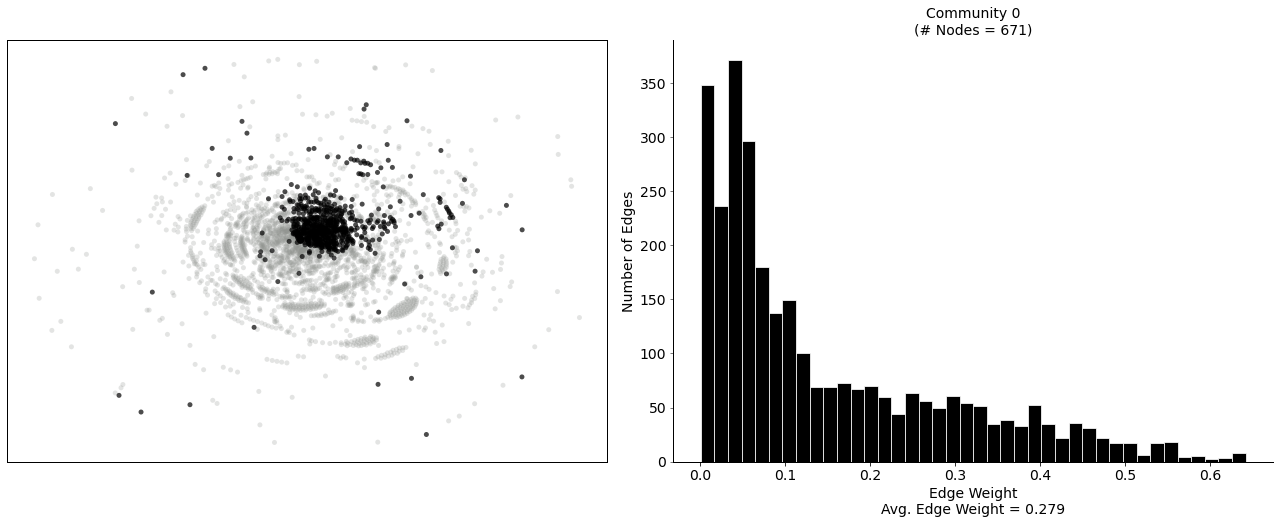

In [181]:
draw_community_subgraph_network_and_edge_weight_distribution(0)

/home/rv76/anaconda2/envs/py36_MRI_virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


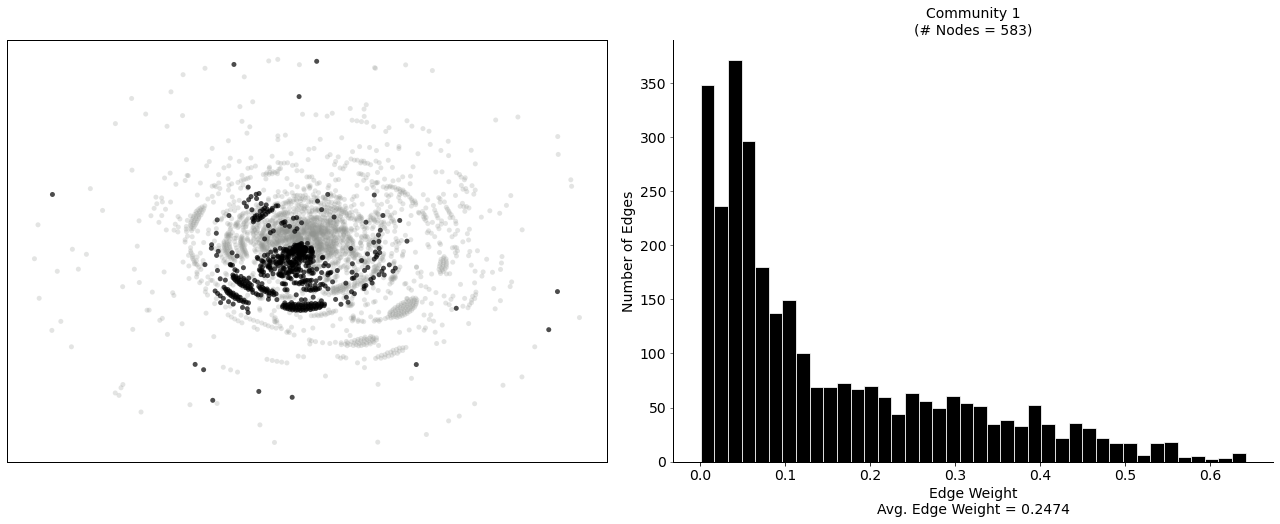

In [182]:
draw_community_subgraph_network_and_edge_weight_distribution(1)

/home/rv76/anaconda2/envs/py36_MRI_virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


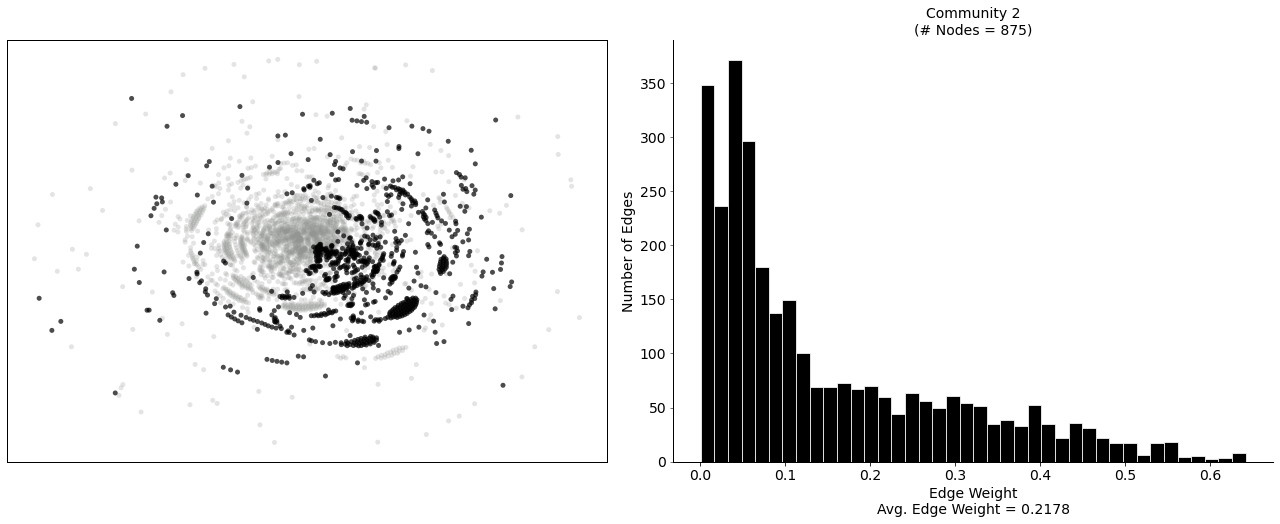

In [183]:
draw_community_subgraph_network_and_edge_weight_distribution(2)

/home/rv76/anaconda2/envs/py36_MRI_virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


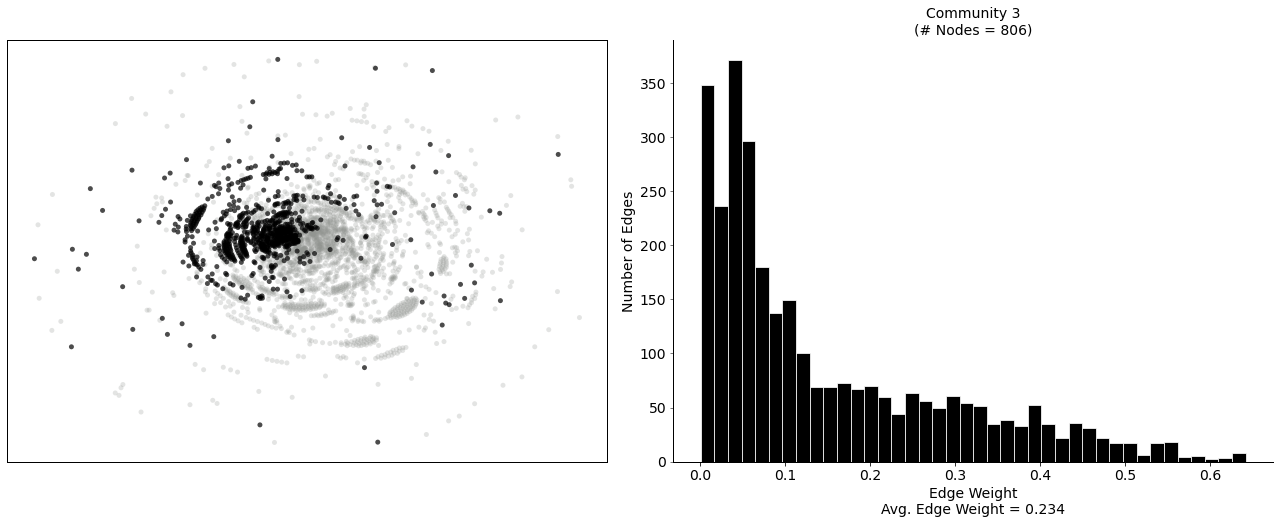

In [184]:
draw_community_subgraph_network_and_edge_weight_distribution(3)

/home/rv76/anaconda2/envs/py36_MRI_virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


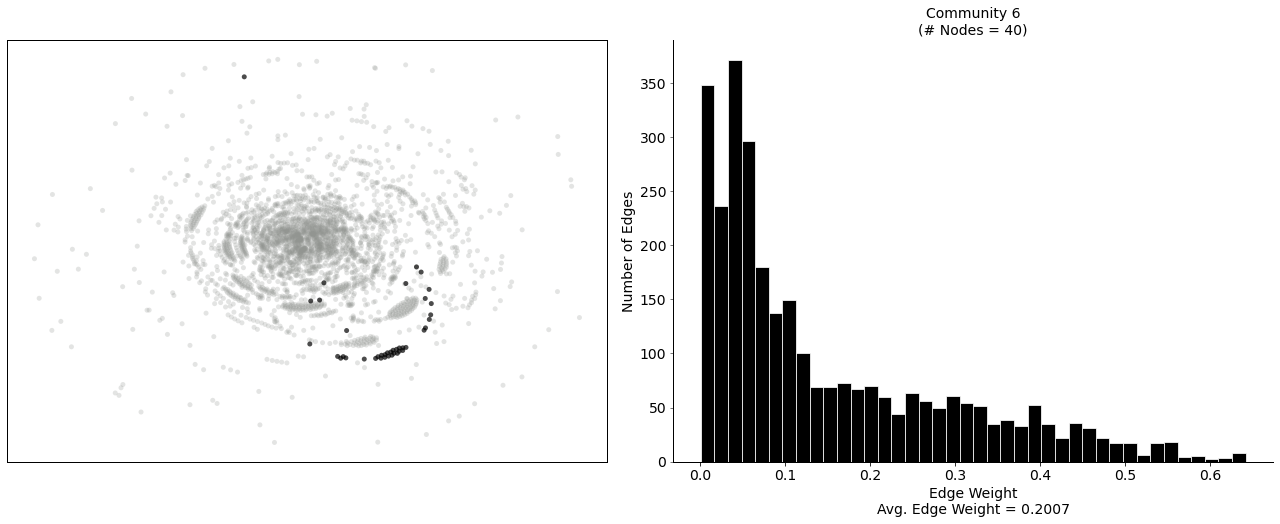

In [186]:
draw_community_subgraph_network_and_edge_weight_distribution(6)

Can convert edge weight matrix into a dataframe with gene labels

In [164]:
network_edge_weight_df = nx.to_pandas_adjacency(G, dtype=float, weight = 'weight')

In [165]:
network_edge_weight_df.head()

,USB1,C12orf57,CD6,ZNF329,BLVRA,CHMP5,P2RY10,TRIM32,BCL3,ACAD11,...,BDP1,MUSTN1,RALGPS2,IGF1R,TBC1D24,HPS1,FAM86B3P,MANBAL,HBG1,HBG2
USB1,0.333333,0.266667,0.266667,0.200000,0.266667,0.200000,0.200000,0.200000,0.200000,0.200000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C12orf57,0.266667,0.600000,0.533333,0.266667,0.400000,0.533333,0.266667,0.266667,0.266667,0.266667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CD6,0.266667,0.533333,0.733333,0.266667,0.600000,0.600000,0.333333,0.266667,0.200000,0.200000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZNF329,0.200000,0.266667,0.266667,0.333333,0.266667,0.200000,0.200000,0.266667,0.200000,0.200000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BLVRA,0.266667,0.400000,0.600000,0.266667,0.666667,0.533333,0.333333,0.000000,0.200000,0.200000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [166]:
np.shape(network_edge_weight_df)

(3005, 3005)